# Adiabatic Quantum Support Vector Machiens

# Install Necessary libaries
**Please install any missing libraries not found locally**.

!pip install numpy <br>
!pip install matplotlib <br>
!pip install sklearn <br>
!pip install time <br>
!pip install dwave-ocean-sdk <br>
!pip install dwave-neal <br>
!pip install pyqubo <br>
!pip install ast <br>

In [ ]:
!pip install numpy 
!pip install matplotlib 
!pip install sklearn 
!pip install time 
!pip install dwave-ocean-sdk 
!pip install dwave-neal 
!pip install pyqubo 
!pip install ast 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
import pandas as pd
from dwave.system import DWaveSampler, EmbeddingComposite
from pyqubo import Array
import ast
import neal

**The below method generates synthetic data points and class labels using specified parameters, allowing for predictable hyperplanes when trained with an SVM**.

**EXPLANATION**: In the below method, we implement a function that generates data points and their corresponding class labels based on the following specified parameters: number of data points, number of features, SVM weights, and SVM bias. 
We generate each data point by sampling the feature values uniformly at random in the range [-1, 1]. We then classify these points based on a linear decision boundary. 
This process iteratively generates the data till we have the desired number of data points. 
This approach allows us to generate synthetic data sets that, when trained with an SVM, result in predictable hyperplanes.

In [6]:
def generate_points2(num_points, weight, b, feat):
    points = []
    y = []
    while len(points)  < num_points/2:
        x = np.random.uniform(-1, 1, feat)
        if 0.7 >= np.inner(weight, x) + b:
            points.append(x.tolist())
            y.append(1)
    while len(points) < num_points:
        x = np.random.uniform(-1, 1, feat)
        if 1.3 < np.inner(weight, x) + b:
            points.append(x.tolist())
            y.append(-1)
    return points, y

**Setup Variables for the classical/quantum SVM:**

- Number of Features.(feat)
- Conditions For Points Generated. (o_weight, o_bias)
- Conditions for classical SVM. (C - Regularization parameter)
- The number of trained and tested points. (nump, N)
- Noise. (Nois)
- Number of Times Annealed. (n_reads)

In [7]:
feat = 2
o_weight = np.tile(np.array([0.5, -0.5]), feat // 2 + 1)[:feat]
o_bias = [1]
C = 1 
nump = 20
N = 20
Nois = 0
n_reads = 10

**Generate points for SVM training and testing.**

- a = trained points
- b = trained labels
- c = tested points
- d = tested labels

Running the cell below plots the training points

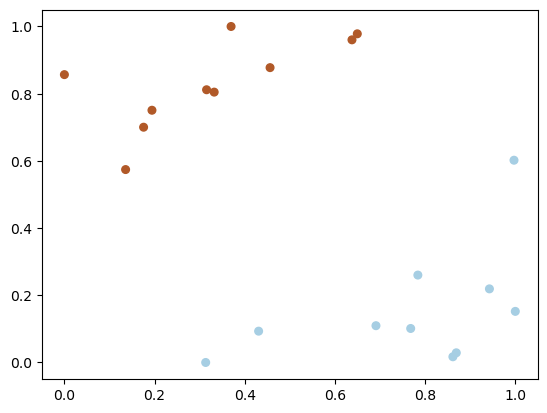

In [8]:
a,b = generate_points2(nump, o_weight, o_bias, feat)
a = np.array(a)  
b = np.array(b)
min_vals = np.min(a, axis=0)
max_vals = np.max(a, axis=0)
a = (a - min_vals) / (max_vals - min_vals)
 
c,d = generate_points2(N, o_weight, o_bias, feat)
c = np.array(c)  
d = np.array(d)
min_vals = np.min(c, axis=0)
max_vals = np.max(c, axis=0)
c = (c - min_vals) / (max_vals - min_vals)

plt.scatter(a[:, 0], a[:, 1], c=b, s=30, cmap=plt.cm.Paired)

**Functions:** 
- Classical SVM. (classical)
  --
  - This function, named classical, performs a linear Support Vector Machine (SVM) classification on input data a and target labels b. It uses Scikit-learn's SVM implementation with the "linear" kernel and a regularization parameter C set to 1. It measures the execution time of the training process, plots the decision boundary of the SVM on a 2D plane, and returns the SVM's coefficients, intercept, number of support vectors, execution time, and indices of the support vectors.

In [20]:
def classical(a,b):
    clf = svm.SVC(kernel="linear", C=1)
    start_time = time.perf_counter()
    clf.fit(a, b)
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    x = np.linspace(0,1,100)
    y = ((-clf.coef_[0][0]*x-clf.intercept_[0])/clf.coef_[0][1])
    plt.plot(x, y, 'r+',label = 'Scikit-learn SVM function')
    return clf.coef_, clf.intercept_, len(clf.support_ ), execution_time, clf.support_,clf

- Quantum SVM. (dwave_annealing, go_fast)
  --
  - go_fast(p, X, y) computes the quadratic programming problem that arises in the context of a Support Vector Machine (SVM). Given a set of data points X and their corresponding labels y, it constructs a quadratic objective function A and a linear term b in the SVM formulation. The function takes the precision vector p as an input and computes A and b using the data X and y. 
  - dwave_annealing(a, b) performs the D-Wave quantum annealing-based SVM training. It calls the go_fast function with a predefined precision vector p, and then it sets up the D-Wave annealing problem using the results from go_fast. It embeds the problem into the D-Wave architecture, samples from it, and then decodes the results to obtain the solution. It returns the learned SVM model's weight vector weight, the bias term bias, the number of support vectors numSVs, and various timing information related to the D-Wave quantum annealing process.
  
- If you have a D-WAVE account that have access to an annealer please fill in your API token 
  --

In [28]:
def dwave_annealing(a,b):
    p = np.array([0.25,0.5,1])
    
    start_time = time.perf_counter()
    f,g = go_fast(p,a,b) 
    s1 = Array.create('b', shape=nump*3, vartype='BINARY')
    H = Array.dot (Array.dot (s1.T,f),s1 ) +Array.dot(s1.T,Array(g))
    model = H.compile()
    bqm = model.to_bqm()
    
    end_time = time.perf_counter()
    preprocessing_time = end_time - start_time
   
    start_time = time.perf_counter()
    sampler = EmbeddingComposite(DWaveSampler(bqm, token='COPY-YOUR-API-TOKEN-HERE'))
    end_time = time.perf_counter()
    embedding_time = end_time - start_time
    
    start_time = time.perf_counter()
    sampleset = sampler.sample(bqm, num_reads=n_reads, return_embedding=True)
    end_time = time.perf_counter()

    
    # Processing the experiment data retrieved
    data_string = str(sampleset.info['timing'])
    data_dict = ast.literal_eval(data_string)
    qpu_access_time = float(data_dict['qpu_access_time']/1000000000)
    qpu_programming_time = float(data_dict['qpu_programming_time']/1000000000)
    network_time = end_time - start_time - qpu_access_time - qpu_programming_time
    
    decoded_samples = model.decode_sampleset(sampleset)
    best_sample = min(decoded_samples, key=lambda x: x.energy)
    answer = np.array(list(best_sample.sample.values()))
    P = np.kron(np.eye(a.shape[0]), p)
    lmda = np.matmul(P, answer)    
   
    weight = np.zeros(feat)
    bias = 0
    support = np.where(lmda != 0)[0].tolist()
    numSVs = len(support)
    if len(support) != 0 :
        weight = np.sum(lmda[support][:, None] * a[support] * b[support][:, None],axis=0)
        bias  = np.sum(b[support] - np.inner(weight.T,a[support]) )/len(support)
        x = np.linspace(0,1,100)
        y = (-(weight[0])*x-bias)/weight[1]
        plt.plot(x, y, 'r', label = 'D-Wave SVM function')
    return weight,bias, numSVs, preprocessing_time, embedding_time , support, sampleset, sampleset.info['embedding_context'], [sampleset.info['timing']] ,network_time,qpu_access_time


- Simulated Annealing SVM. (simulated_annealing)
  --
  - simulated_annealing(a, b) performs a simulated quantum annealing-based SVM training. It calls the go_fast function with a predefined precision vector p, and then it sets up the annealing problem using the results from go_fast. It samples the problem then decodes the results to obtain the solution. It returns the learned SVM model's weight vector weight, the bias term bias, the number of support vectors numSVs, and various timing information related to the simulated annealing process.

In [26]:
def simulated_annealing(a,b):
    p = np.array([0.25,0.5,1])
    start_time = time.perf_counter()
    f,g = go_fast(p,a,b) 
    N = a.shape[0] 
    P = np.kron(np.eye(N), p)
    s1 = Array.create('b', shape=nump*3, vartype='BINARY')
    H = Array.dot (Array.dot (s1.T,f),s1 ) +Array.dot(s1.T,Array(g))
    model = H.compile()
    bqm = model.to_bqm()
    end_time = time.perf_counter()
    preprocessing_time = end_time - start_time
    
    start_time = time.perf_counter()
    sa = neal.SimulatedAnnealingSampler()
    sampleset = sa.sample(bqm, num_reads=n_reads)
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    
    decoded_samples = model.decode_sampleset(sampleset)
    best_sample = min(decoded_samples, key=lambda x: x.energy)
    answer = np.array(list(best_sample.sample.values()))
    P = np.kron(np.eye(a.shape[0]), p)
    lmda = np.matmul(P, answer)
    
    weight = np.zeros(feat)
    bias = 0
    support = np.where(lmda != 0)[0].tolist()
    numSVs = len(support)
    if len(support) != 0 :
        weight = np.sum(lmda[support][:, None] * a[support] * b[support][:, None],axis=0)
        bias  = np.sum(b[support] - np.inner(weight.T,a[support]) )/len(support)
        x = np.linspace(0,1,100)
        y = (-(weight[0])*x-bias)/weight[1]
        plt.plot(x, y, '--r',label = 'Simualted Annealing SVM function')
    return weight, bias, numSVs , preprocessing_time , execution_time, support

- Accuracy Evaluation (score_svm, evalulate_svm)
  -- 
  - These two functions implement a Support Vector Machine (SVM) classifier: the first function computes the SVM scores and predicts the class labels for a set of points based on the given weight and bias, while the second function evaluates the accuracy of the SVM predictions by comparing them to the correct labels.
- Classical SVM. (classical)

In [23]:
def score_svm(weight, bias, points):
    num_points = len(points)
    scores = np.zeros(num_points)
    
    for i in range(num_points):
        dot_product = np.dot(weight, points[i]) 
        scores[i] = dot_product + bias 
        
    predictions = np.where(scores > 0, 1, -1)  
    return predictions

def evaluate_svm(predictions, correct_labels):
    num_points = len(predictions)
    correct = np.sum(predictions == correct_labels) 
    accuracy = correct / num_points
    return accuracy

def go_fast(p,X,y):
    N = X.shape[0] 
    P = np.kron(np.eye(N), p)
    A = 0.5 * P.T @ (np.multiply(X@X.T, np.outer(y, y))) @ P
    b = - P.T @ np.ones(N)
    return A, b

**Call The Functions!**

Below call the classical and simulated annealers

1.0
1.0
0.0014592999998512823
1.0
1.0
0.039800000000013824
0.020154400000137684


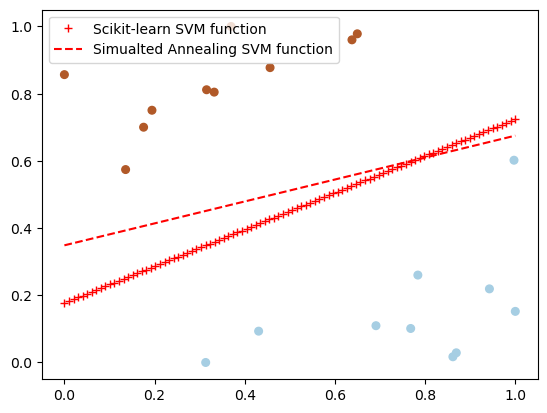

In [32]:
weightCL , biasCL, NumberOfSupportVectorsCL, execution_timeCL, support_vectorsCL,clf = classical(a,b)
trainingerrorCL =  evaluate_svm(score_svm(weightCL, biasCL, a), b)
testingerrorCL =  evaluate_svm(score_svm(weightCL, biasCL, c), d)
print(trainingerrorCL)   
print(testingerrorCL)
print(execution_timeCL)

weightSA , biasSA, NumberOfSupportVectorsSA, preprocessing_timeSA , execution_timeSA , support_vectorsSA= simulated_annealing(a,b) 
trainingerrorSA =  evaluate_svm(score_svm(weightSA, biasSA, a), b)
testingerrorSA =  evaluate_svm(score_svm(weightSA, biasSA, c), d)
print(trainingerrorSA)   
print(testingerrorSA)
print(preprocessing_timeSA)
print(execution_timeSA)

plt.legend()
plt.scatter(a[:, 0], a[:, 1], c=b, s=30, cmap=plt.cm.Paired)

If you have a D-Wave account with access to an annealer.

1.0
1.0
0.043767200000047524
1.423639299999877
1.716617e-05


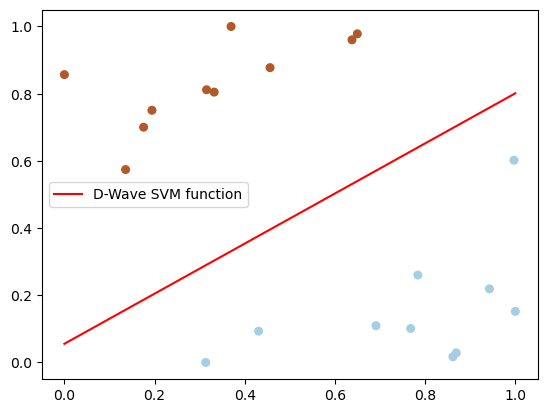

In [33]:
weightDW , biasDW, NumberOfSupportVectorsDW, preprocessing_timeDW, embedding_timeDW , support_vectorsDW ,sampleset,info, timeDW,network_time,qpu_access_time = dwave_annealing(a,b)
trainingerrorDW =  evaluate_svm(score_svm(weightDW, biasDW, a), b)
testingerrorDW =  evaluate_svm(score_svm(weightDW, biasDW, c), d)
plt.legend()
plt.scatter(a[:, 0], a[:, 1], c=b, s=30, cmap=plt.cm.Paired)
print(trainingerrorDW)   
print(testingerrorDW)
print(preprocessing_timeDW)
print(embedding_timeDW)
print(qpu_access_time)